In [91]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
#
import os
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
#
from sklearn.preprocessing import LabelEncoder
make_lb = LabelEncoder()
#
from sklearn.preprocessing import LabelBinarizer
lbb = LabelBinarizer()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# Data Cleaning & Exploration

In [2]:
df = pd.read_csv('student_data.csv')

In [3]:
df.rename(columns={'default payment next month': 'default'}, inplace=True)
df.columns=df.columns.str.lower()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 25 columns):
id           23999 non-null int64
limit_bal    23999 non-null int64
sex          23999 non-null int64
education    23999 non-null int64
marriage     23999 non-null int64
age          23999 non-null int64
pay_0        23999 non-null int64
pay_2        23999 non-null int64
pay_3        23999 non-null int64
pay_4        23999 non-null int64
pay_5        23999 non-null int64
pay_6        23999 non-null int64
bill_amt1    23999 non-null int64
bill_amt2    23999 non-null int64
bill_amt3    23999 non-null int64
bill_amt4    23999 non-null int64
bill_amt5    23999 non-null int64
bill_amt6    23999 non-null int64
pay_amt1     23999 non-null int64
pay_amt2     23999 non-null int64
pay_amt3     23999 non-null int64
pay_amt4     23999 non-null int64
pay_amt5     23999 non-null int64
pay_amt6     23999 non-null int64
default      23999 non-null int64
dtypes: int64(25)
memory usage: 4.6 MB


#### For Reference

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.  

Found this to only be slightly helpful. Not so much cleaning but more wrangling will be involved.

In [5]:
df['default'].value_counts()

0    18691
1     5308
Name: default, dtype: int64

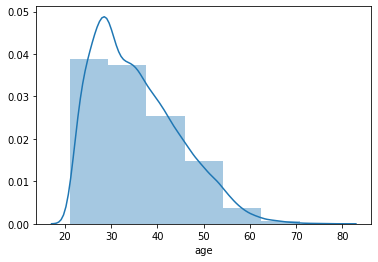

In [6]:
# Viewing the distribution of age in the data
sns.distplot(df['age'], bins = 7)

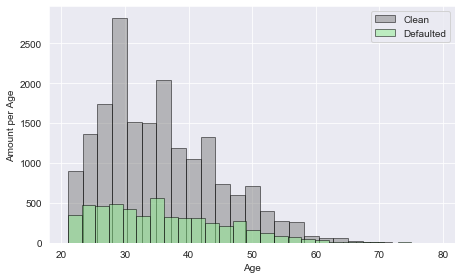

In [7]:
# Plotting total number 'clean' with the total number 'defaulted' over it
# There is a bit of a misalignment with the distribution
# Ages should be binned
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(df[df['default'] ==0].age, bins = 25, label ='Clean', alpha = .50,edgecolor= 'black',color ='grey')
ax1.hist(df[df['default']==1].age, bins = 25, label = 'Defaulted', alpha = .50, edgecolor = 'black',color = 'lightgreen')
ax1.set_xlabel('Age')
ax1.set_ylabel('Amount per Age')
ax1.legend(loc = 'upper right')

In [8]:
# Binning then getting dummies for age groups

df['age_bin'] = pd.cut(df['age'], 6, labels=['20s', '30s', '40s', '50s', '60s', '70s'])
df[['age', 'age_bin']]
dums = pd.get_dummies(df['age_bin'], drop_first=True)
df.drop(columns=['age'], axis=1, inplace=True)
dums = pd.get_dummies(df['age_bin'], drop_first=True)
df = df.join(dums)

In [9]:
df.groupby('default')['age_bin'].value_counts()

default  age_bin
0        20s        6827
         30s        6791
         40s        3681
         50s        1187
         60s         192
         70s          13
1        20s        1985
         30s        1727
         40s        1128
         50s         398
         60s          64
         70s           6
Name: age_bin, dtype: int64

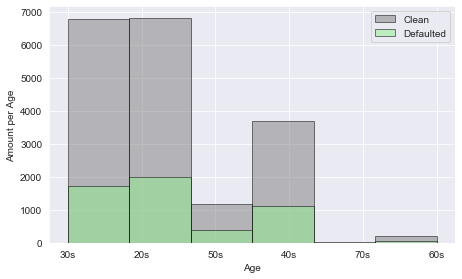

In [10]:
###### sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(df[df['default'] ==0].age_bin, bins = 6, label ='Clean', alpha = .50,edgecolor= 'black',color ='grey')
ax1.hist(df[df['default']==1].age_bin, bins = 6, label = 'Defaulted', alpha = .50, edgecolor = 'black',color = 'lightgreen')
ax1.set_xlabel('Age')
ax1.set_ylabel('Amount per Age')
ax1.legend(loc = 'upper right')

A bit wonky but still gives a good idea of how the `default` classification is spread out throughout age groups. Those between 20-40 make up most of this data.

In [11]:
# Can now delete the `age_bin` column since we have dummies
df.drop(columns=['age_bin'], axis=1, inplace=True)

In [12]:
# Making sex a binary term
# Dropping the `sex` column and replacing with gender
gender = []
for x in df['sex']:
    if x == 1:
        gender.append(1)
    elif x == 2:
        gender.append(0)

df['gender'] = gender
df.drop(columns=['sex'], axis=1, inplace=True)

In [13]:
# Since I don't know what is above 4 in regards to education, I am going to bin 
# All of the education types into their labeled types, except all above 4 are `others`
# Making dummies for the different education levels

df['edu'] = pd.cut(df['education'], 4, labels=['grad', 'undergrad', 'highschool', 'others'])
df[['edu', 'education']]
dums = pd.get_dummies(df['edu'], drop_first=True)
df.drop(columns=['education'], axis=1, inplace=True)

In [14]:
# Adding the dummies, dropping the old column
df = df.join(dums)
df.drop(columns=['edu'], axis=1, inplace=True)

In [15]:
df.drop(columns=['marriage', 'id',], axis=1, inplace=True)

In [16]:
# Manually MinMax scaling the continuous columns
# Normalization

col_to_norm = ['limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
              'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
df[col_to_norm] = df[col_to_norm].apply(lambda x: (x - x.min()) /(x.max() - x.min()), axis=0)

Bit of a divergence here. I want to see what happens if I just make the `pay_x` columns either 0 or 1. 0 for not late/on time, 1 for late. Not sure if this will help or hurt, which is why I am going to diverge a separate data frame for that.

In [17]:
df2 = df
df2.loc[df2.pay_0 <= 0, 'pay_0'] = 0
df2.loc[df2.pay_0 > 0, 'pay_0'] = 1
df2.loc[df2.pay_2 <= 0, 'pay_2'] = 0
df2.loc[df2.pay_2 > 0, 'pay_2'] = 1
df2.loc[df2.pay_3 <= 0, 'pay_3'] = 0
df2.loc[df2.pay_3 > 0, 'pay_3'] = 1
df2.loc[df2.pay_4 <= 0, 'pay_4'] = 0
df2.loc[df2.pay_4 > 0, 'pay_4'] = 1
df2.loc[df2.pay_5 <= 0, 'pay_5'] = 0
df2.loc[df2.pay_5 > 0, 'pay_5'] = 1
df2.loc[df2.pay_6 <= 0, 'pay_6'] = 0
df2.loc[df2.pay_6 > 0, 'pay_6'] = 1

In [18]:
# Adding a new column that might be useful
# Is a continuous column that is the addition or total number of times
# Individual was late on payment over the past 6 months
# Experimental feature
df2['pay_sum'] = df2.apply(lambda row: row.pay_0 + row.pay_2 + row.pay_3 + row.pay_4 + row.pay_5 + row.pay_6, axis=1)

# View to see
df2.head()
df2.groupby('default')['pay_sum'].value_counts()

default  pay_sum
0        0.0        14055
         1.0         2506
         2.0          923
         3.0          458
         4.0          333
         6.0          314
         5.0          102
1        0.0         1880
         1.0         1063
         6.0          753
         2.0          566
         3.0          474
         4.0          435
         5.0          137
Name: pay_sum, dtype: int64

Here is a good question: `Is the proportion of those who defaulted having multiple late payments higher than that of those who did not default?`  
  

Another good question: `Is the proportion of those who defaulted having zero late payments lower than that of those who did not default?`

In [37]:
df2.head()

,limit_bal,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,30s,40s,50s,60s,70s,gender,undergrad,highschool,others,pay_sum
0,0.343434,0,0,0,0,0,0,0.146799,0.064522,0.086518,0.160577,0.081110,0.261222,0.000362,0.000188,0.000520,0.000750,0.000741,0.000598,0,1,0,0,0,0,1,0,0,0,0.0
1,0.040404,1,1,1,0,0,0,0.182794,0.105682,0.107330,0.172408,0.093804,0.271351,0.006296,0.000000,0.000647,0.000966,0.001407,0.001135,0,1,0,0,0,0,0,1,0,0,3.0
2,0.040404,0,0,0,0,0,0,0.149554,0.066578,0.087607,0.164659,0.090375,0.261486,0.002917,0.001378,0.005357,0.015797,0.001547,0.005637,0,0,0,0,0,0,0,0,0,0,0.0
3,0.010101,0,0,0,0,1,0,0.156118,0.075801,0.093418,0.173122,0.093955,0.271496,0.001726,0.000722,0.001245,0.000000,0.001149,0.001245,0,0,0,1,0,0,1,1,0,0,1.0
4,0.101010,0,0,0,0,0,0,0.242227,0.165806,0.145896,0.262653,0.190273,0.342501,0.006182,0.003206,0.004576,0.006602,0.009612,0.007945,0,1,0,0,0,0,0,1,0,0,0.0


In [38]:
df2.groupby('default')['pay_sum'].describe()
# Are these means different? The question is, is the mean for non-defaulted
# Customers lower than that for those who did default?

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,18691.0,0.505698,1.150107,0.0,0.0,0.0,0.0,6.0
1,5308.0,1.989450,2.130004,0.0,0.0,1.0,3.0,6.0


In [56]:
t_test = stats.ttest_ind(df2.loc[lambda df2: df2['default'] == 0]['pay_sum'],
                         df2.loc[lambda df2: df2['default'] == 1]['pay_sum'], axis=0, equal_var=False)
# t-critical value is 1.282 from chart
if t_test[0] > 1.282:
    print('Can reject the null hypothesis that the means of the two groups\narethesame in favor of the alternate stating the mean price of hosts who respond 100% of the time is higher than hosts who do not respond 100% of the time.')
else:
    print('Cannot reject the null hypothesis.')

Cannot reject the null hypothesis.


In [57]:
t_test

Ttest_indResult(statistic=-48.772263328096315, pvalue=0.0)

On time percentage?  
0 on time, 1 anything over 0. Total 1's / Total Entries

In [58]:
df2['ot_percentage'] = (df2['pay_sum']/6)

In [60]:
df2.head()
df2.drop(columns=['log_otp'], axis=1, inplace=True)

In [61]:
df2.head()

,limit_bal,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,30s,40s,50s,60s,70s,gender,undergrad,highschool,others,pay_sum,ot_percentage
0,0.343434,0,0,0,0,0,0,0.146799,0.064522,0.086518,0.160577,0.081110,0.261222,0.000362,0.000188,0.000520,0.000750,0.000741,0.000598,0,1,0,0,0,0,1,0,0,0,0.0,0.000000
1,0.040404,1,1,1,0,0,0,0.182794,0.105682,0.107330,0.172408,0.093804,0.271351,0.006296,0.000000,0.000647,0.000966,0.001407,0.001135,0,1,0,0,0,0,0,1,0,0,3.0,0.500000
2,0.040404,0,0,0,0,0,0,0.149554,0.066578,0.087607,0.164659,0.090375,0.261486,0.002917,0.001378,0.005357,0.015797,0.001547,0.005637,0,0,0,0,0,0,0,0,0,0,0.0,0.000000
3,0.010101,0,0,0,0,1,0,0.156118,0.075801,0.093418,0.173122,0.093955,0.271496,0.001726,0.000722,0.001245,0.000000,0.001149,0.001245,0,0,0,1,0,0,1,1,0,0,1.0,0.166667
4,0.101010,0,0,0,0,0,0,0.242227,0.165806,0.145896,0.262653,0.190273,0.342501,0.006182,0.003206,0.004576,0.006602,0.009612,0.007945,0,1,0,0,0,0,0,1,0,0,0.0,0.000000


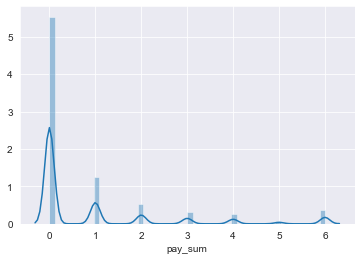

In [62]:
sns.distplot(df2['pay_sum'])

In [66]:
df2.drop(columns=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0], axis=1, inplace=True)

In [68]:
pay_dums = pd.get_dummies(df2['pay_sum'], prefix='ot_sum', drop_first=True)
df2 = df2.join(pay_dums)


In [69]:
df2.head()

,limit_bal,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,30s,40s,50s,60s,70s,gender,undergrad,highschool,others,pay_sum,ot_percentage,ot_sum_1.0,ot_sum_2.0,ot_sum_3.0,ot_sum_4.0,ot_sum_5.0,ot_sum_6.0
0,0.343434,0,0,0,0,0,0,0.146799,0.064522,0.086518,0.160577,0.081110,0.261222,0.000362,0.000188,0.000520,0.000750,0.000741,0.000598,0,1,0,0,0,0,1,0,0,0,0.0,0.000000,0,0,0,0,0,0
1,0.040404,1,1,1,0,0,0,0.182794,0.105682,0.107330,0.172408,0.093804,0.271351,0.006296,0.000000,0.000647,0.000966,0.001407,0.001135,0,1,0,0,0,0,0,1,0,0,3.0,0.500000,0,0,1,0,0,0
2,0.040404,0,0,0,0,0,0,0.149554,0.066578,0.087607,0.164659,0.090375,0.261486,0.002917,0.001378,0.005357,0.015797,0.001547,0.005637,0,0,0,0,0,0,0,0,0,0,0.0,0.000000,0,0,0,0,0,0
3,0.010101,0,0,0,0,1,0,0.156118,0.075801,0.093418,0.173122,0.093955,0.271496,0.001726,0.000722,0.001245,0.000000,0.001149,0.001245,0,0,0,1,0,0,1,1,0,0,1.0,0.166667,1,0,0,0,0,0
4,0.101010,0,0,0,0,0,0,0.242227,0.165806,0.145896,0.262653,0.190273,0.342501,0.006182,0.003206,0.004576,0.006602,0.009612,0.007945,0,1,0,0,0,0,0,1,0,0,0.0,0.000000,0,0,0,0,0,0


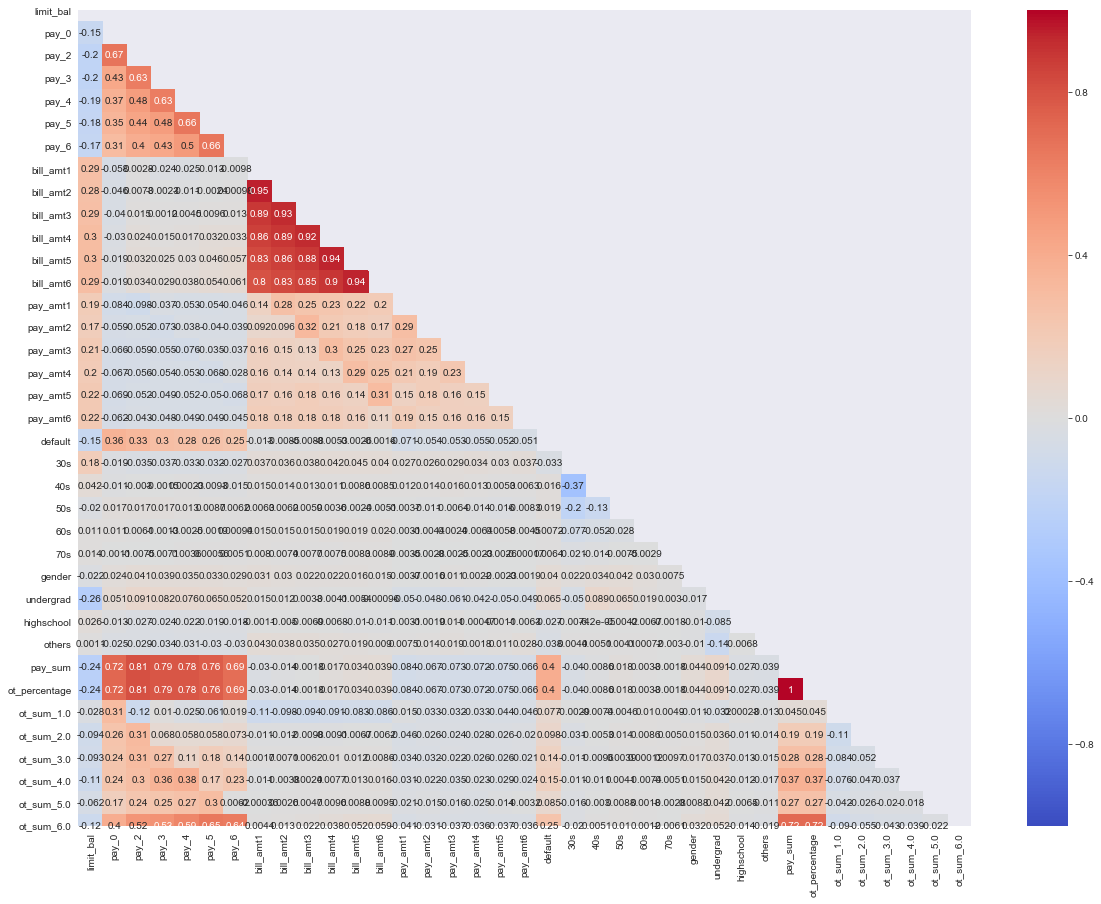

In [74]:
f, ax = plt.subplots(figsize=(20, 15))
matrix = np.triu(df2.corr())
sns.heatmap(df2.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

Still seems that pay_x is the most strongly interacting variable with my target. I am going to make three models. All variables included, then I am going to start manually stripping them off. And then finally I will use a feature selection method.

---

# Model Creation

In [75]:
# All features, including ones I was going to drop
X = df2.drop(columns=['default'], axis=1)
y = df2.default
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25)


In [77]:
# Fitting a baseline LogReg model
logreg = LogisticRegression(C=1e14, solver='lbfgs', fit_intercept=False)
model_1_allfeats = logreg.fit(X_train, y_train)
allfeats_coef = dict(zip(list(X_train.columns), list(model_1_allfeats.coef_[0])))

In [82]:
y_train_pred = model_1_allfeats.predict(X_train)
y_test_pred = model_1_allfeats.predict(X_test)

In [83]:
train_report = classification_report(y_train, y_train_pred)
test_report = classification_report(y_test, y_test_pred)

In [85]:
print(train_report)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     14034
           1       0.63      0.31      0.41      3965

    accuracy                           0.81     17999
   macro avg       0.73      0.63      0.65     17999
weighted avg       0.79      0.81      0.78     17999



In [92]:
# First calculate the probability scores of each of the datapoints:
y_test_scores = model_1_allfeats.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)

In [94]:
auc(fpr, tpr)

0.7483352789122324

---

In [108]:
def make_log(data):
    X = data.drop(columns=['default'], axis=1)
    y = data.default   
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25)
    
    logreg = LogisticRegression(C=1e14, solver='lbfgs', fit_intercept=False)
    model = logreg.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred)
    
    y_test_scores = model.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
    
    print(auc(fpr, tpr))
    print('Train Report:','\n',train_report)
    print('Test Report:','\n',test_report)

In [103]:
# Model 2
# Removing variables with multicollinearity
drop = ['pay_sum', 'ot_percentage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
mod2_df2 = df2.drop(columns=drop, axis=1)


In [105]:
mod2_df2

,limit_bal,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,30s,40s,50s,60s,70s,gender,undergrad,highschool,others,ot_sum_1.0,ot_sum_2.0,ot_sum_3.0,ot_sum_4.0,ot_sum_5.0,ot_sum_6.0
0,0.343434,0.146799,0.064522,0.086518,0.160577,0.081110,0.261222,0.000362,0.000188,0.000520,0.000750,0.000741,0.000598,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.040404,0.182794,0.105682,0.107330,0.172408,0.093804,0.271351,0.006296,0.000000,0.000647,0.000966,0.001407,0.001135,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0.040404,0.149554,0.066578,0.087607,0.164659,0.090375,0.261486,0.002917,0.001378,0.005357,0.015797,0.001547,0.005637,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.010101,0.156118,0.075801,0.093418,0.173122,0.093955,0.271496,0.001726,0.000722,0.001245,0.000000,0.001149,0.001245,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0
4,0.101010,0.242227,0.165806,0.145896,0.262653,0.190273,0.342501,0.006182,0.003206,0.004576,0.006602,0.009612,0.007945,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,0.040404,0.157851,0.077051,0.086345,0.160138,0.080648,0.260979,0.008611,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23995,0.242424,0.152559,0.067931,0.088805,0.201158,0.118378,0.261421,0.004492,0.002661,0.048743,0.061459,0.001350,0.004519,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
23996,0.040404,0.183531,0.104784,0.111562,0.202424,0.127900,0.298420,0.002061,0.002375,0.000000,0.005636,0.004689,0.000000,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
23997,0.101010,0.319458,0.232008,0.121012,0.197680,0.089863,0.259989,0.005724,0.005937,0.005634,0.003221,0.093682,0.098361,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [109]:
make_log(mod2_df2)

0.7475703714102391
Train Report: 
               precision    recall  f1-score   support

           0       0.83      0.95      0.88     14034
           1       0.62      0.30      0.41      3965

    accuracy                           0.81     17999
   macro avg       0.73      0.63      0.65     17999
weighted avg       0.78      0.81      0.78     17999

Test Report: 
               precision    recall  f1-score   support

           0       0.82      0.95      0.88      4657
           1       0.62      0.30      0.41      1343

    accuracy                           0.80      6000
   macro avg       0.72      0.62      0.64      6000
weighted avg       0.78      0.80      0.77      6000



---


In [ ]:
# Model 3
